In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull

Cloning into 'ERA_V1'...
remote: Enumerating objects: 593, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 593 (delta 34), reused 48 (delta 27), pack-reused 535
Receiving objects: 100% (593/593), 8.73 MiB | 35.46 MiB/s, done.
Resolving deltas: 100% (329/329), done.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_9")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from cifar10.utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions
from cifar10.model import Model_Net, model_summary, model_train, model_test
from cifar10.data_loader import load_cifar10_data

Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cifar_10_model = Model_Net(base_channels=3,num_classes=10).to(device)
model_summary(cifar_10_model, input_size=(3,32,32))
#from torchviz import make_dot
#x = torch.zeros(1,3,32,32,dtype=torch.float, requires_grad=False)
#y  = cifar_10_model(x)
#cifar_model_dot = make_dot(y.mean(), params = dict(list(cifar_10_model.named_parameters())))
#cifar_model_dot.format='png'
#cifar_model_dot.render("model_dot_representation.png")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
       BatchNorm2d-2            [-1, 3, 32, 32]               6
              ReLU-3            [-1, 3, 32, 32]               0
           Dropout-4            [-1, 3, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]             192
            Conv2d-6           [-1, 64, 32, 32]             576
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
           Dropout-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]           8,192
           Conv2d-11           [-1, 64, 30, 30]          73,728
      BatchNorm2d-12           [-1, 64, 30, 30]             128
             ReLU-13           [-1, 64, 30, 30]               0
          Dropout-14           [-1, 64,

/content/ERA_V1/session_9/cifar10/model.py:209: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit = 0.05, scale_limit = 0.05, rotate_limit=10.,p=0.1),
        A.HorizontalFlip(p=0.1),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=16,
                                                max_width=16, min_holes = 1,
                                                min_height=16, min_width=16,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 64
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

100%|██████████| 170498071/170498071 [00:01<00:00, 104617557.36it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Show sample Images from the dataset

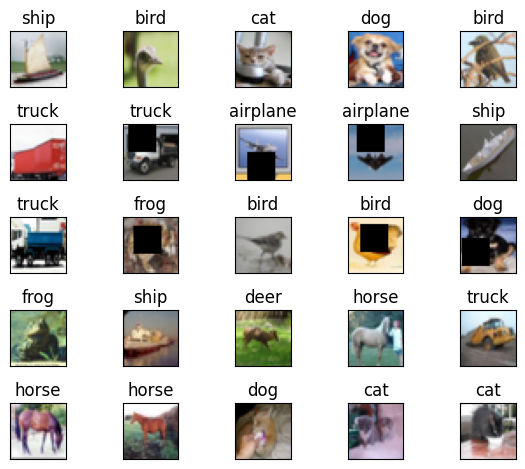

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

In [7]:
drop_out = 0.02
num_epochs=40
model_bn = Model_Net(base_channels=3, num_classes=10, drop_out = drop_out).to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.1,verbose=True)
train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_bn, device, train_loader, optimizer, train_acc_bn, train_losses_bn)
    this_loss = model_test(model_bn, device, test_loader, test_acc_bn, test_losses_bn)
    scheduler.step(this_loss)
target_test_acc = 85.


epoch: 1


loss=1.151787519454956 batch_id=781 Accuracy = 43.01: 100%|██████████| 782/782 [00:30<00:00, 25.88it/s]



Test set: Average loss: 1.1657, Accuracy: 5646/10000 (56.46%)

epoch: 2


loss=1.2203162908554077 batch_id=781 Accuracy = 57.71: 100%|██████████| 782/782 [00:29<00:00, 26.24it/s]



Test set: Average loss: 1.1839, Accuracy: 5861/10000 (58.61%)

epoch: 3


loss=1.0431993007659912 batch_id=781 Accuracy = 62.22: 100%|██████████| 782/782 [00:30<00:00, 25.72it/s]



Test set: Average loss: 1.0056, Accuracy: 6407/10000 (64.07%)

epoch: 4


loss=1.4028096199035645 batch_id=781 Accuracy = 65.23: 100%|██████████| 782/782 [00:29<00:00, 26.51it/s]



Test set: Average loss: 0.8795, Accuracy: 6853/10000 (68.53%)

epoch: 5


loss=0.9575093984603882 batch_id=781 Accuracy = 67.87: 100%|██████████| 782/782 [00:30<00:00, 25.86it/s]



Test set: Average loss: 0.9068, Accuracy: 6770/10000 (67.70%)

epoch: 6


loss=0.588584840297699 batch_id=781 Accuracy = 69.39: 100%|██████████| 782/782 [00:29<00:00, 26.31it/s]



Test set: Average loss: 0.7822, Accuracy: 7341/10000 (73.41%)

epoch: 7


loss=0.8492971658706665 batch_id=781 Accuracy = 70.79: 100%|██████████| 782/782 [00:31<00:00, 24.68it/s]



Test set: Average loss: 0.7854, Accuracy: 7307/10000 (73.07%)

epoch: 8


loss=0.8091483116149902 batch_id=781 Accuracy = 72.05: 100%|██████████| 782/782 [00:29<00:00, 26.24it/s]



Test set: Average loss: 0.7594, Accuracy: 7348/10000 (73.48%)

epoch: 9


loss=1.3542301654815674 batch_id=781 Accuracy = 72.90: 100%|██████████| 782/782 [00:30<00:00, 25.51it/s]



Test set: Average loss: 0.7140, Accuracy: 7523/10000 (75.23%)

epoch: 10


loss=0.7731094360351562 batch_id=781 Accuracy = 74.08: 100%|██████████| 782/782 [00:30<00:00, 25.85it/s]



Test set: Average loss: 0.7092, Accuracy: 7506/10000 (75.06%)

Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.
epoch: 11


loss=0.41675880551338196 batch_id=781 Accuracy = 77.55: 100%|██████████| 782/782 [00:30<00:00, 26.06it/s]



Test set: Average loss: 0.5654, Accuracy: 8026/10000 (80.26%)

epoch: 12


loss=0.4419131278991699 batch_id=781 Accuracy = 78.34: 100%|██████████| 782/782 [00:30<00:00, 25.74it/s]



Test set: Average loss: 0.5594, Accuracy: 8053/10000 (80.53%)

epoch: 13


loss=0.7623136043548584 batch_id=781 Accuracy = 78.72: 100%|██████████| 782/782 [00:29<00:00, 26.17it/s]



Test set: Average loss: 0.5623, Accuracy: 8086/10000 (80.86%)

epoch: 14


loss=1.3385995626449585 batch_id=781 Accuracy = 78.91: 100%|██████████| 782/782 [00:30<00:00, 25.78it/s]



Test set: Average loss: 0.5598, Accuracy: 8116/10000 (81.16%)

epoch: 15


loss=0.42349353432655334 batch_id=781 Accuracy = 78.98: 100%|██████████| 782/782 [00:29<00:00, 26.22it/s]



Test set: Average loss: 0.5472, Accuracy: 8157/10000 (81.57%)

Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
epoch: 16


loss=0.8384152054786682 batch_id=781 Accuracy = 79.66: 100%|██████████| 782/782 [00:30<00:00, 25.74it/s]



Test set: Average loss: 0.5410, Accuracy: 8142/10000 (81.42%)

epoch: 17


loss=0.6393880844116211 batch_id=781 Accuracy = 79.70: 100%|██████████| 782/782 [00:29<00:00, 26.27it/s]



Test set: Average loss: 0.5415, Accuracy: 8151/10000 (81.51%)

epoch: 18


loss=1.247411847114563 batch_id=781 Accuracy = 79.72: 100%|██████████| 782/782 [00:30<00:00, 25.69it/s]



Test set: Average loss: 0.5422, Accuracy: 8149/10000 (81.49%)

epoch: 19


loss=0.3716408908367157 batch_id=781 Accuracy = 79.80: 100%|██████████| 782/782 [00:30<00:00, 25.49it/s]



Test set: Average loss: 0.5426, Accuracy: 8166/10000 (81.66%)

Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.
epoch: 20


loss=0.6106386780738831 batch_id=781 Accuracy = 79.64: 100%|██████████| 782/782 [00:30<00:00, 25.72it/s]



Test set: Average loss: 0.5408, Accuracy: 8166/10000 (81.66%)

epoch: 21


loss=0.4954785108566284 batch_id=781 Accuracy = 79.75: 100%|██████████| 782/782 [00:29<00:00, 26.16it/s]



Test set: Average loss: 0.5412, Accuracy: 8158/10000 (81.58%)

epoch: 22


loss=0.4104756712913513 batch_id=781 Accuracy = 79.89: 100%|██████████| 782/782 [00:29<00:00, 26.14it/s]



Test set: Average loss: 0.5429, Accuracy: 8156/10000 (81.56%)

epoch: 23


loss=1.137019157409668 batch_id=781 Accuracy = 79.97: 100%|██████████| 782/782 [00:30<00:00, 25.82it/s]



Test set: Average loss: 0.5418, Accuracy: 8150/10000 (81.50%)

Epoch 00023: reducing learning rate of group 0 to 1.0000e-06.
epoch: 24


loss=0.7952808737754822 batch_id=781 Accuracy = 79.71: 100%|██████████| 782/782 [00:29<00:00, 26.11it/s]



Test set: Average loss: 0.5424, Accuracy: 8164/10000 (81.64%)

epoch: 25


loss=0.5299738049507141 batch_id=781 Accuracy = 79.74: 100%|██████████| 782/782 [00:30<00:00, 25.92it/s]



Test set: Average loss: 0.5435, Accuracy: 8144/10000 (81.44%)

epoch: 26


loss=0.804692268371582 batch_id=781 Accuracy = 79.86: 100%|██████████| 782/782 [00:29<00:00, 26.18it/s]



Test set: Average loss: 0.5404, Accuracy: 8156/10000 (81.56%)

epoch: 27


loss=0.47738176584243774 batch_id=781 Accuracy = 79.83: 100%|██████████| 782/782 [00:30<00:00, 25.69it/s]



Test set: Average loss: 0.5404, Accuracy: 8162/10000 (81.62%)

Epoch 00027: reducing learning rate of group 0 to 1.0000e-07.
epoch: 28


loss=0.6338443160057068 batch_id=781 Accuracy = 79.54: 100%|██████████| 782/782 [00:30<00:00, 25.97it/s]



Test set: Average loss: 0.5404, Accuracy: 8169/10000 (81.69%)

epoch: 29


loss=0.6386803388595581 batch_id=781 Accuracy = 79.91: 100%|██████████| 782/782 [00:31<00:00, 25.08it/s]



Test set: Average loss: 0.5433, Accuracy: 8152/10000 (81.52%)

epoch: 30


loss=0.27242785692214966 batch_id=781 Accuracy = 79.86: 100%|██████████| 782/782 [00:29<00:00, 26.18it/s]



Test set: Average loss: 0.5404, Accuracy: 8149/10000 (81.49%)

epoch: 31


loss=0.8336487412452698 batch_id=781 Accuracy = 79.80: 100%|██████████| 782/782 [00:30<00:00, 25.61it/s]



Test set: Average loss: 0.5421, Accuracy: 8132/10000 (81.32%)

Epoch 00031: reducing learning rate of group 0 to 1.0000e-08.
epoch: 32


loss=0.9651651978492737 batch_id=781 Accuracy = 79.75: 100%|██████████| 782/782 [00:30<00:00, 26.05it/s]



Test set: Average loss: 0.5423, Accuracy: 8159/10000 (81.59%)

epoch: 33


loss=0.7646386027336121 batch_id=781 Accuracy = 79.87: 100%|██████████| 782/782 [00:30<00:00, 25.72it/s]



Test set: Average loss: 0.5394, Accuracy: 8154/10000 (81.54%)

epoch: 34


loss=0.7848079800605774 batch_id=781 Accuracy = 79.87: 100%|██████████| 782/782 [00:29<00:00, 26.21it/s]



Test set: Average loss: 0.5399, Accuracy: 8154/10000 (81.54%)

epoch: 35


loss=0.7078927755355835 batch_id=781 Accuracy = 80.04: 100%|██████████| 782/782 [00:30<00:00, 25.86it/s]



Test set: Average loss: 0.5402, Accuracy: 8160/10000 (81.60%)

epoch: 36


loss=0.5207880735397339 batch_id=781 Accuracy = 79.88: 100%|██████████| 782/782 [00:29<00:00, 26.34it/s]



Test set: Average loss: 0.5409, Accuracy: 8176/10000 (81.76%)

epoch: 37


loss=0.295743465423584 batch_id=781 Accuracy = 79.74: 100%|██████████| 782/782 [00:30<00:00, 25.61it/s]



Test set: Average loss: 0.5416, Accuracy: 8143/10000 (81.43%)

epoch: 38


loss=0.9656097888946533 batch_id=781 Accuracy = 79.95: 100%|██████████| 782/782 [00:29<00:00, 26.24it/s]



Test set: Average loss: 0.5430, Accuracy: 8160/10000 (81.60%)

epoch: 39


loss=0.8162907958030701 batch_id=781 Accuracy = 79.77: 100%|██████████| 782/782 [00:30<00:00, 25.58it/s]



Test set: Average loss: 0.5415, Accuracy: 8150/10000 (81.50%)

epoch: 40


loss=0.4152827262878418 batch_id=781 Accuracy = 80.09: 100%|██████████| 782/782 [00:29<00:00, 26.22it/s]



Test set: Average loss: 0.5426, Accuracy: 8156/10000 (81.56%)



Plot results for Batch Norm experiment

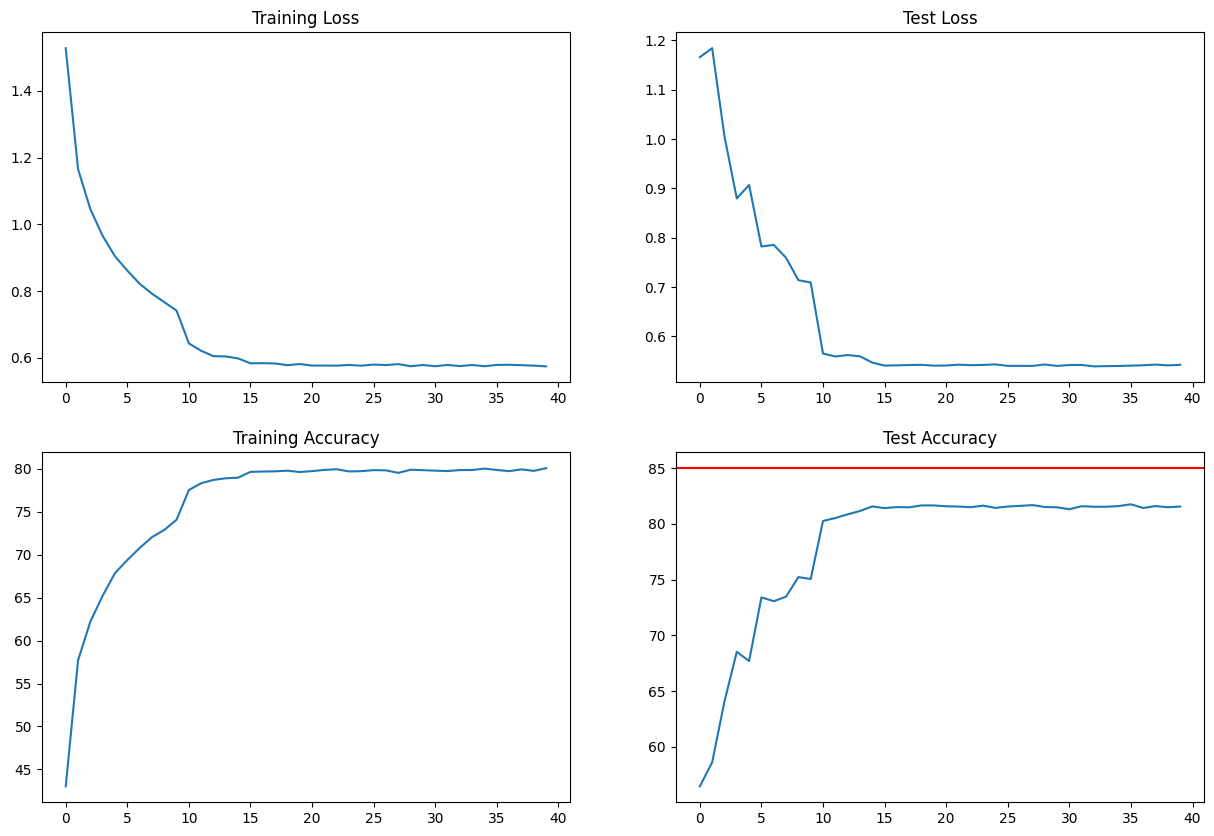

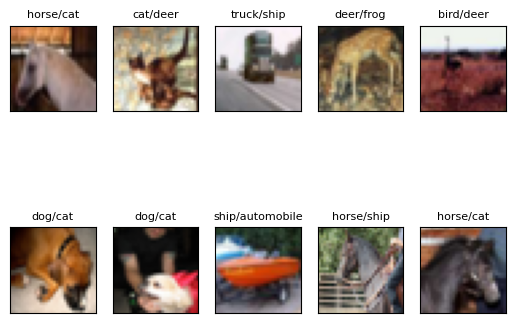

In [8]:
plot_statistics(train_losses_bn, train_acc_bn, test_losses_bn, test_acc_bn, target_test_acc)
incorrect_predictions_bn = get_incorrect_predictions(model_bn, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)